In [ ]:
import os
import sys
import itertools

input_folder = 'API_responses'
output_folder = 'extracted_response'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']
for tell, prompt, length, order, sample_num in itertools.product(tells, prompts, lengths, orders, range(1, 21)):
    input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                            f'order_{order}.txt')
    output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                f'order_{order}.txt')
    with open(input_fn, 'r') as file:
        lines = file.readlines()
        answer_line = lines[0]
        answers = answer_line.split()
        if 'Answer:' in answers:
            answers.remove('Answer:')
        extracted = ' '.join(answers)
    if not os.path.exists(os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}')):
        os.makedirs(os.path.join(output_folder, tell, prompt,
                    f'length_{length}', f'sample_{sample_num}'))
    with open(output_fn, 'w') as file:
        file.writelines(extracted)

In [68]:
"""Process GPT-4 data"""
import os
import sys
import copy
import itertools
import numpy as np
import pprint

input_folder = 'extracted_response'
answer_folder = 'data_ToMh_old'
response_folder = 'API_responses'
output_folder = 'check_GPT-4'
summary_file = 'GPT-4_data.txt'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']
CoT_count, CoT_correct = [0, 0]
MC_count, MC_correct = [0, 0]
summary_lines = []
accuracy_data = {'Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))},
                'No_Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))}}
correctness_for_each = {'Tell': {'CoT': np.zeros((3, 5, 20)), 'MC': np.zeros((3, 5, 20))},
                'No_Tell': {'CoT': np.zeros((3, 5, 20)), 'MC': np.zeros((3, 5, 20))}}
cnt_vs_deception = np.zeros((5, 3))
correct_vs_deception = np.zeros((5, 3))

for tell, prompt, length, order in itertools.product(tells, prompts, lengths, orders):
    out_folder = os.path.join(output_folder, tell, prompt, f'length_{length}', f'order_{order}')
    summary_lines.append(f'{tell}, {prompt}, {length} chapters, {order} order: ')
    
    total_count = 0
    correct_count = 0

    for sample_num in range(1, 21):
        total_count += 1
        input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                f'order_{order}.txt')
        response_fn = os.path.join(response_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                f'order_{order}.txt')
        answer_fn = os.path.join(answer_folder, tell, 'CoT', f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
        output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')

        with open(answer_fn, 'r') as file:
            output_lines = file.readlines()
        count_deception = 0
        with open(answer_fn, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if 'Answer:' in line.split(' '):
                    correct_answer = line.split(' ', 1)[1].split('\n')[0]
                    output_lines.append('Correct answer: ' + correct_answer + '\n')
                if 'privately' in line.split(' ') or 'publicly' in line.split(' '):
                    count_deception += 1
        cnt_vs_deception[order][count_deception // 2] += 1
        
        with open(input_fn, 'r') as file:
            lines = file.readlines()
            if len(lines[0].split(' ')) == 2:
                answer_line = lines[0].split(' ')[1]
                output_lines.append('GPT-4 Answer: ' + answer_line + '\n')
            else:
                # print(f"Eliminated: {tell}, {prompt}, {length} chapters, {order} order, " , lines)
                continue
        with open(response_fn, 'r') as file:
            lines = file.readlines()
            output_lines.append('GPT-4 Explain: ')
            output_lines += lines
                    
        if answer_line == correct_answer:
            correct_count += 1
            correct_vs_deception[order][count_deception // 2] += 1
        
        if not os.path.exists(os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}')):
            os.makedirs(os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}'))
        with open(output_fn, 'w') as file:
            file.writelines(output_lines)
    accuracy = correct_count / total_count
    summary_lines.append(str(accuracy) + '\n')
    accuracy_data[tell][prompt][length - 1][order] = accuracy
    with open(summary_file, 'w') as file:
        file.writelines(summary_lines)
pprint.pprint(accuracy_data)
pprint.pprint(cnt_vs_deception)
pprint.pprint(correct_vs_deception)

{'No_Tell': {'CoT': array([[1.  , 0.8 , 0.8 , 0.65, 0.6 ],
       [0.95, 0.8 , 0.5 , 0.35, 0.3 ],
       [0.95, 0.55, 0.3 , 0.4 , 0.45]]),
             'MC': array([[1.  , 0.7 , 0.75, 0.7 , 0.65],
       [0.95, 0.8 , 0.45, 0.15, 0.25],
       [0.7 , 0.55, 0.35, 0.4 , 0.4 ]])},
 'Tell': {'CoT': array([[0.75, 0.65, 0.5 , 0.5 , 0.3 ],
       [1.  , 0.55, 0.45, 0.5 , 0.5 ],
       [1.  , 0.45, 0.45, 0.3 , 0.15]]),
          'MC': array([[1.  , 0.6 , 0.4 , 0.4 , 0.45],
       [1.  , 0.6 , 0.6 , 0.45, 0.55],
       [0.95, 0.45, 0.4 , 0.3 , 0.2 ]])}}
array([[120.,  80.,  40.],
       [120.,  80.,  40.],
       [120.,  80.,  40.],
       [120.,  80.,  40.],
       [120.,  80.,  40.]])
array([[111.,  75.,  39.],
       [ 84.,  48.,  18.],
       [ 63.,  39.,  17.],
       [ 53.,  37.,  12.],
       [ 53.,  36.,   7.]])


In [ ]:
"""Plot heatmap for GPT-4"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

accuracy_data['Tell']['CoT'][0][0] = 1.0
accuracy_data['Tell']['CoT'][2][0] = 0.75

for tell, prompt in itertools.product(tells, prompts):
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(accuracy_data[tell][prompt], cmap=mpl.colormaps['Blues'])

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5), rotation=45)
    ax.set_yticks(np.arange(3), labels=[1, 2, 3])
    ax.set_xlabel('ToM order')
    ax.set_ylabel('Story length')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Accuracy", rotation=-90, va="bottom")
    communication = 'Exist deception' if tell == 'Tell' else 'No deception'
    ax.set_title(f'{communication}, {prompt} prompting')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(3):
        for j in range(5):
            fontcolor = 'black' if accuracy_data[tell][prompt][i][j] < 0.8 else 'white'
            text = ax.text(j, i, accuracy_data[tell][prompt][i][j],
                        ha="center", va="center", color=fontcolor)

    fig.tight_layout()
    plt.savefig(f'data_figs/{tell}_{prompt}.pdf')
    plt.show()

In [71]:
"""Count joint accuracy."""
import os
import sys
import copy
import itertools
import numpy as np
import pprint

input_folder = 'extracted_response'
answer_folder = 'data_ToMh_old'
response_folder = 'API_responses'
output_folder = 'check_GPT-4'
summary_file = 'GPT-4_data.txt'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']
CoT_count, CoT_correct = [0, 0]
MC_count, MC_correct = [0, 0]
summary_lines = []
joint_accuracy_data = {'Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))},
                'No_Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))}}
joint_cnt_vs_deception = np.zeros((5, 7))
joint_correct_vs_deception = np.zeros((5, 7))
deception = set()

for tell, prompt, length in itertools.product(tells, prompts, lengths):
    
    total_count = np.zeros(5)
    correct_count = np.zeros(5)

    for sample_num in range(1, 21):
        correct_so_far = True
        for i, order in enumerate(orders):
            input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            response_fn = os.path.join(response_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            answer_fn = os.path.join(answer_folder, tell, 'CoT', f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            count_deception = 0
            with open(answer_fn, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    if 'Answer:' in line.split(' '):
                        correct_answer = line.split(' ', 1)[1].split('\n')[0]
                    if 'privately' in line.split(' '):
                        count_deception += 1
                    if 'publicly' in line.split(' '):
                        count_deception += 2
            
            joint_cnt_vs_deception[order][count_deception] += 1
            
            with open(input_fn, 'r') as file:
                lines = file.readlines()
                if len(lines[0].split(' ')) == 2:
                    answer_line = lines[0].split(' ')[1]
                else:
                    # print(f"Eliminated: {tell}, {prompt}, {length} chapters, {order} order, " , lines)
                    continue
            
            total_count[i] += 1
            if answer_line == correct_answer and correct_so_far:
                correct_count[i] += 1
                joint_correct_vs_deception[order][count_deception] += 1
            elif answer_line != correct_answer:
                correct_so_far = False
    for order in orders:
        joint_accuracy_data[tell][prompt][length - 1][order] = correct_count[order] / total_count[order]
# print(deception)
pprint.pprint(joint_accuracy_data)
# pprint.pprint(joint_cnt_vs_deception)
# pprint.pprint(joint_correct_vs_deception)

{'No_Tell': {'CoT': array([[1.        , 0.84210526, 0.7       , 0.45      , 0.35      ],
       [0.95      , 0.78947368, 0.5       , 0.2       , 0.1       ],
       [0.95      , 0.55      , 0.2       , 0.15789474, 0.15      ]]),
             'MC': array([[1.        , 0.7       , 0.5       , 0.45      , 0.4       ],
       [0.95      , 0.75      , 0.35      , 0.1       , 0.05      ],
       [0.93333333, 0.57894737, 0.2       , 0.15      , 0.15      ]])},
 'Tell': {'CoT': array([[1.        , 0.65      , 0.3       , 0.2       , 0.15      ],
       [1.        , 0.55      , 0.2       , 0.1       , 0.1       ],
       [1.        , 0.45      , 0.3       , 0.1       , 0.05263158]]),
          'MC': array([[1.        , 0.6       , 0.2       , 0.1       , 0.1       ],
       [1.        , 0.6       , 0.35      , 0.15      , 0.15      ],
       [0.95      , 0.4       , 0.21052632, 0.05      , 0.05      ]])}}


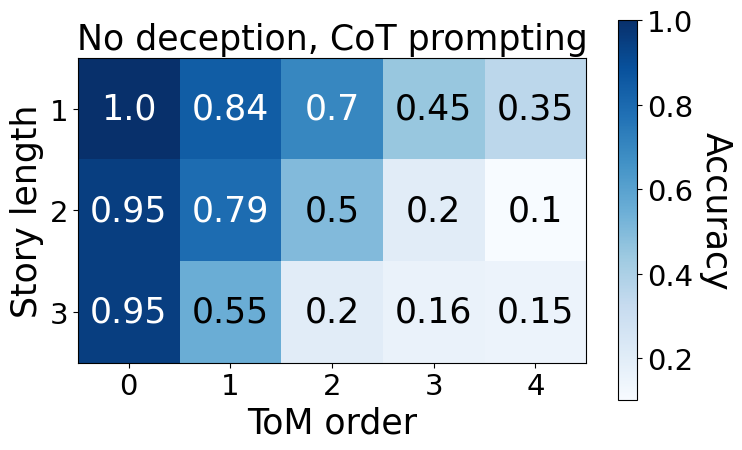

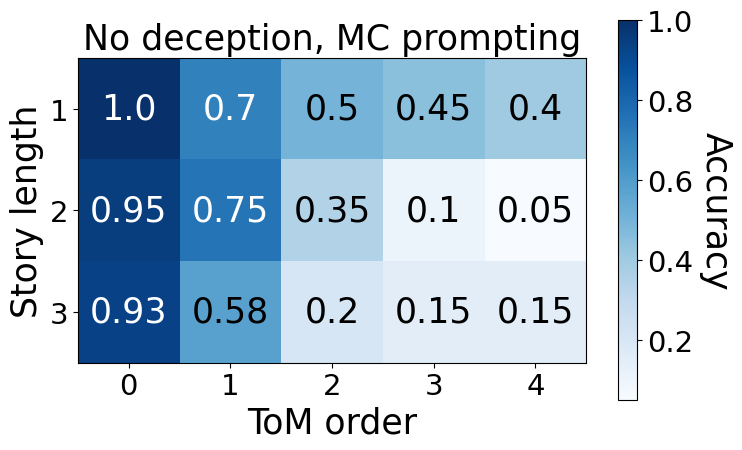

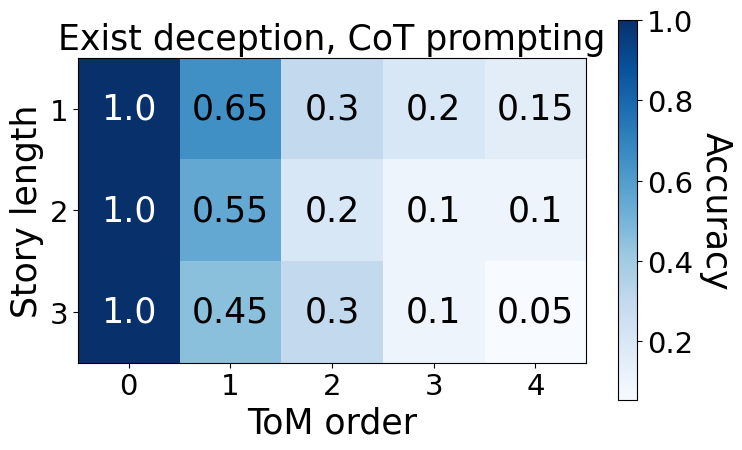

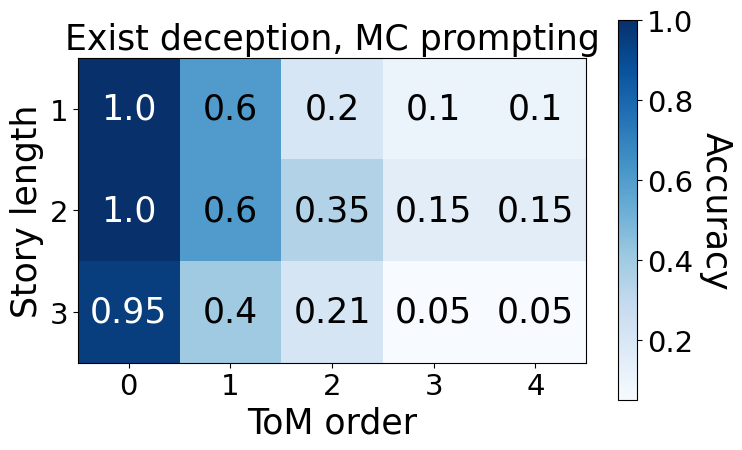

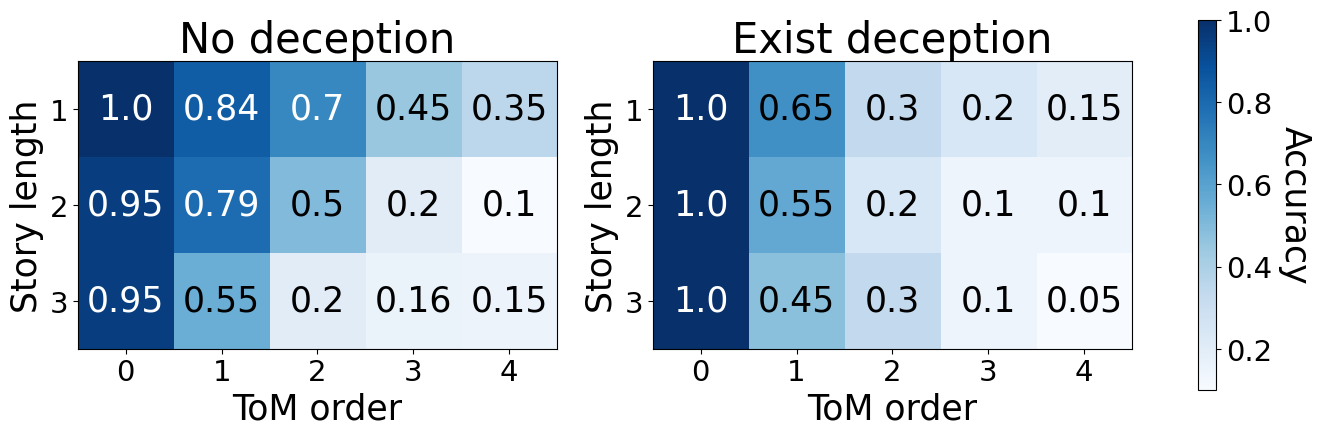

In [92]:
"""Plot joint accuracy heatmap for GPT-4"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"


for tell, prompt in itertools.product(tells, prompts):
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(joint_accuracy_data[tell][prompt], cmap=mpl.colormaps['Blues'])

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5), rotation=45)
    ax.set_yticks(np.arange(3), labels=[1, 2, 3])
    ax.set_xlabel('ToM order')
    ax.set_ylabel('Story length')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Accuracy", rotation=-90, va="bottom")
    communication = 'Exist deception' if tell == 'Tell' else 'No deception'
    ax.set_title(f'{communication}, {prompt} prompting')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(3):
        for j in range(5):
            rounded = np.round(joint_accuracy_data[tell][prompt], 2)
            fontcolor = 'black' if joint_accuracy_data[tell][prompt][i][j] < 0.7 else 'white'
            text = ax.text(j, i, rounded[i][j],
                        ha="center", va="center", color=fontcolor)

    fig.tight_layout()
    plt.savefig(f'data_figs/{tell}_{prompt}.pdf')

"""Plot 2 combined heatmaps"""
fig, axs = plt.subplots(1, 2, figsize=(17,8))
im1 = axs[0].imshow(joint_accuracy_data['No_Tell']['CoT'], cmap=mpl.colormaps['Blues'])
im2 = axs[1].imshow(joint_accuracy_data['Tell']['CoT'], cmap=mpl.colormaps['Blues'])

# Show all ticks and label them with the respective list entries
for i in range(2):
    axs[i].set_xticks(np.arange(5), rotation=45)
    axs[i].set_yticks(np.arange(3), labels=[1, 2, 3])
    axs[i].set_xlabel('ToM order')
    axs[i].set_ylabel('Story length')
    communication = 'Exist deception' if i == 1 else 'No deception'
    axs[i].set_title(communication, fontsize=TITLE_FONT_SIZE)

# Loop over data dimensions and create text annotations.
for i in range(3):
    for j in range(5):
        rounded = np.round(joint_accuracy_data['No_Tell']['CoT'], 2)
        fontcolor = 'black' if joint_accuracy_data['No_Tell']['CoT'][i][j] < 0.7 else 'white'
        text = axs[0].text(j, i, rounded[i][j],
                    ha="center", va="center", color=fontcolor)
for i in range(3):
    for j in range(5):
        rounded = np.round(joint_accuracy_data['Tell']['CoT'], 2)
        fontcolor = 'black' if joint_accuracy_data['Tell']['CoT'][i][j] < 0.7 else 'white'
        text = axs[1].text(j, i, rounded[i][j],
                    ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.6)
cbar.ax.set_ylabel('Accuracy', rotation=-90, va="bottom")
plt.savefig(f'data_figs/CoT_heatmaps.pdf')

In [ ]:
"""Accuracy vs. deception times"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

markers = ['o', 's', '^', 'D', '.']
acc_vs_deception = np.zeros((5, 3))

for order in range(1, 5):
    for deception_num in range(3):
        acc_vs_deception[order][deception_num] = correct_vs_deception[order][deception_num] / cnt_vs_deception[order][deception_num]
print(acc_vs_deception)

colors = ['steelblue', 'orange', 'lightcoral']
plt.figure(figsize=(8, 5)) 
for i, acc in enumerate(acc_vs_deception):
    # plt.plot([0, 2, 4], acc, label=[0, 2, 4], marker=markers[i], color=colors[i], linewidth=2.6, markersize=10)
    if i == 0:
        continue
    plt.plot([0, 2, 4], acc, linewidth=2.6, marker=markers[i], markersize=9, label=f'Order {i}')

# 添加标题和轴标签
# plt.title('Multiple Line Plot')
ax = plt.gca()
plt.xlabel('Number of deception per story', labelpad=10)
plt.ylabel('Accuracy')
plt.ylim(0.1, 0.7)
plt.xticks([0, 2, 4])
plt.grid(axis='y', linestyle='dashed', which='both')
# plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('silver')
plt.tick_params(axis='x', which='both', bottom=False, pad=10)
plt.tick_params(left=False)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3, frameon=False)
plt.subplots_adjust(bottom=0.2, top=0.9)

plt.savefig('linechart.pdf')
plt.show()

[[0.925      0.         0.92857143 0.94230769 0.         0.94444444
  1.        ]
 [0.68333333 0.         0.64285714 0.57692308 0.         0.5
  0.36363636]
 [0.40833333 0.         0.28571429 0.25       0.         0.27777778
  0.22727273]
 [0.25       0.         0.17857143 0.11538462 0.         0.05555556
  0.09090909]
 [0.2        0.         0.17857143 0.09615385 0.         0.
  0.09090909]]


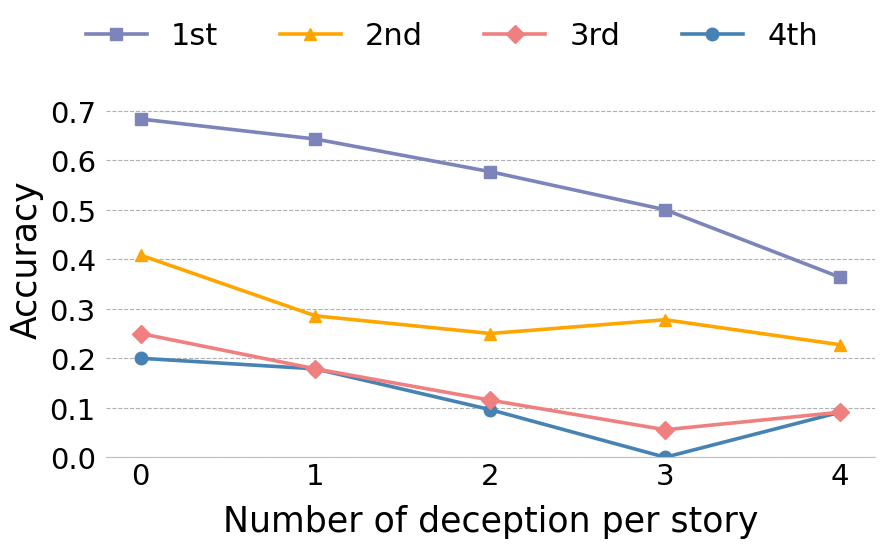

In [94]:
"""Joint accuracy vs. deception times"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

markers = ['.', 's', '^', 'D', 'o']
joint_acc_vs_deception = np.zeros((5, 7))
order_label = ['0th', '1st', '2nd', '3rd', '4th']

for order in range(5):
    for deception_num in [0,2,3,5,6]:
        joint_acc_vs_deception[order][deception_num] = joint_correct_vs_deception[order][deception_num] / joint_cnt_vs_deception[order][deception_num]
print(joint_acc_vs_deception)

joint_acc_vs_deception = joint_acc_vs_deception[:, [0,2,3,5,6]]
colors = ['neglect', '#7C84B9', 'orange', 'lightcoral', 'steelblue']
plt.figure(figsize=(9, 5.5)) 
for i, acc in enumerate(joint_acc_vs_deception):
    if i == 0:
        continue
    zorder = 3 if i == 3 else 2
    plt.plot([0,1,2,3,4], acc, linewidth=2.6, marker=markers[i], markersize=9, label=order_label[i], color=colors[i], zorder=zorder)

# 添加标题和轴标签
# plt.title('Multiple Line Plot')
ax = plt.gca()
plt.xlabel('Number of deception per story', labelpad=10)
plt.ylabel('Accuracy')
plt.ylim(0, 0.8)
plt.xticks([0,1,2,3,4])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
plt.grid(axis='y', linestyle='dashed', which='both')
# plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('silver')
plt.tick_params(axis='x', which='both', bottom=False, pad=0)
plt.tick_params(left=False)
# plt.yscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.45, 1.17), ncol=4, frameon=False)
plt.subplots_adjust(bottom=0.15, top=0.87, right=0.98)

plt.savefig('data_figs/jointacc_vs_deception.pdf')
plt.show()

In [346]:
"""Analyze correct answers"""
import os
import sys
import copy
import itertools
import numpy as np
import pprint

input_folder = 'extracted_response'
answer_folder = 'data_ToMh_old'
response_folder = 'API_responses'
output_folder = 'check_GPT-4'
summary_file = 'GPT-4_data.txt'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']

# Count answer occurrence
container_nums = 0
story_cnt = 0
max_container = 0
correct_ans_occur = np.zeros(5)
cnt_correct = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
cnt_correct_same = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
cnt_incorrect = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
cnt_incorrect_same = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}

joint_count_correct = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
joint_count_correct_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_correct = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_correct_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_incorrect = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_incorrect_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
first_count = np.zeros(5)
first_correct_count = np.zeros(5)
notfirst_count = np.zeros(5)
notfirst_correct_count = np.zeros(5)
containers = ['green_box.', 'blue_box.', 'red_box.', 'green_pantry.', 'blue_pantry.', 'red_pantry.', 'green_bathtub.', 'blue_bathtub.', 'red_bathtub.', 'green_envelope.', 'blue_envelope.', 'red_envelope.', 'green_drawer.', 'blue_drawer.', 'red_drawer.', 'green_bottle.', 'blue_bottle.', 'red_bottle.', 'green_cupboard.', 'blue_cupboard.', 'red_cupboard.', 'green_basket.', 'blue_basket.', 'red_basket.', 'green_crate.', 'blue_crate.', 'red_crate.', 'green_suitcase.', 'blue_suitcase.', 'red_suitcase.', 'green_bucket.', 'blue_bucket.', 'red_bucket.', 'green_container.', 'blue_container.', 'red_container.', 'green_treasure_chest.', 'blue_treasure_chest.', 'red_treasure_chest.']


for tell, prompt, length in itertools.product(tells, prompts, lengths):
    for sample_num in range(1, 21):
        correct_so_far = True
        prev_ans = None
        for order in orders:
            input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            response_fn = os.path.join(response_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            answer_fn = os.path.join(answer_folder, tell, 'CoT', f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            with open(answer_fn, 'r') as file:
                lines = file.readlines()
                answer_pool = []
                answer_lines = []
                story_total_line = len(lines) - 5
                splits = np.array_split(list(range(story_total_line)), 5)
                for line_num, line in enumerate(lines):
                    if 'Answer:' in line.split(' '):
                        correct_answer = line.split(' ', 1)[1].split('\n')[0]
                    # check if sentence contains a container
                    elif 'likes' not in line.split(' '):
                        container = [container for container in line.split() if container in containers]
                        answer_pool += container
                if order <= 4:
                    for line_num, line in enumerate(lines):
                        if correct_answer + '.' in line:
                            for i, split in enumerate(splits):
                                if line_num in split:
                                    correct_ans_occur[i] += 1

            story_cnt += 1
            container_nums += len(answer_pool)
            if len(answer_pool) > max_container:
                max_container = len(answer_pool)
            with open(input_fn, 'r') as file:
                lines = file.readlines()
                if len(lines[0].split(' ')) == 2:
                    answer_line = lines[0].split(' ')[1]
                else:
                    continue
            
            # Same-as-last answer count
            if order >= 1:
                if answer_line == correct_answer and correct_so_far:
                    cnt_correct[tell][order] += 1
                    if correct_answer == prev_ans:
                        cnt_correct_same[tell][order] += 1
                elif answer_line != correct_answer:
                    cnt_incorrect[tell][order] += 1
                    if correct_answer == prev_ans:
                        cnt_incorrect_same[tell][order] += 1
            prev_ans = correct_answer

            # Answer occurrence count
            if length in [3]:
                if tell == 'No_Tell':
                    if correct_answer + '.' in answer_pool[-1]:
                        first_count[order] += 1
                        if answer_line == correct_answer:
                            first_correct_count[order] += 1
                    else:
                        notfirst_count[order] += 1
                        if answer_line == correct_answer:
                            notfirst_correct_count[order] += 1

            # Ratio of correct answers being the first
            if answer_line == correct_answer:
                count_correct[tell][order] += 1
                if correct_answer + '.' in answer_pool[0]:
                    count_correct_first[tell][order] += 1
            elif answer_line != correct_answer:
                count_incorrect[tell][order] += 1
                if answer_line + '.' in answer_pool[0]:
                    count_incorrect_first[tell][order] += 1
            
            # Ratio of joint correct answers being the first
            if answer_line == correct_answer and correct_so_far:
                joint_count_correct[tell][order] += 1
                if correct_answer + '.' in answer_pool[:2]:
                    joint_count_correct_first[tell][order] += 1
            elif answer_line != correct_answer:
                correct_so_far = False

for tell in tells:
    for order in orders:
        print(cnt_correct_same[tell][order] / cnt_correct[tell][order])
    for order in orders:
        print(cnt_incorrect_same[tell][order] / cnt_incorrect[tell][order])  
# print(max_container)
# print('avg. container: ', container_nums / story_cnt)
# print(correct_ans_occur)
# print(first_count)
# print('avg:')
# print(np.mean(first_correct_count[3:]) / np.mean(first_count[3:]))
# print(np.mean(notfirst_correct_count[3:]) / np.mean(notfirst_count[3:]))
# print(np.mean(first_correct_count) / np.mean(first_count))
# print(np.mean(notfirst_correct_count) / np.mean(notfirst_count))


nan
0.5853658536585366
0.7755102040816326
0.9333333333333333
1.0
nan
0.5454545454545454
0.2545454545454545
0.7272727272727273
0.9104477611940298
nan
0.6461538461538462
0.7741935483870968
0.9285714285714286
1.0
nan
0.2222222222222222
0.42857142857142855
0.5633802816901409
0.8552631578947368


/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_67883/1283238786.py:130: RuntimeWarning: invalid value encountered in double_scalars
  print(cnt_correct_same[tell][order] / cnt_correct[tell][order])
/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_67883/1283238786.py:132: RuntimeWarning: invalid value encountered in double_scalars
  print(cnt_incorrect_same[tell][order] / cnt_incorrect[tell][order])


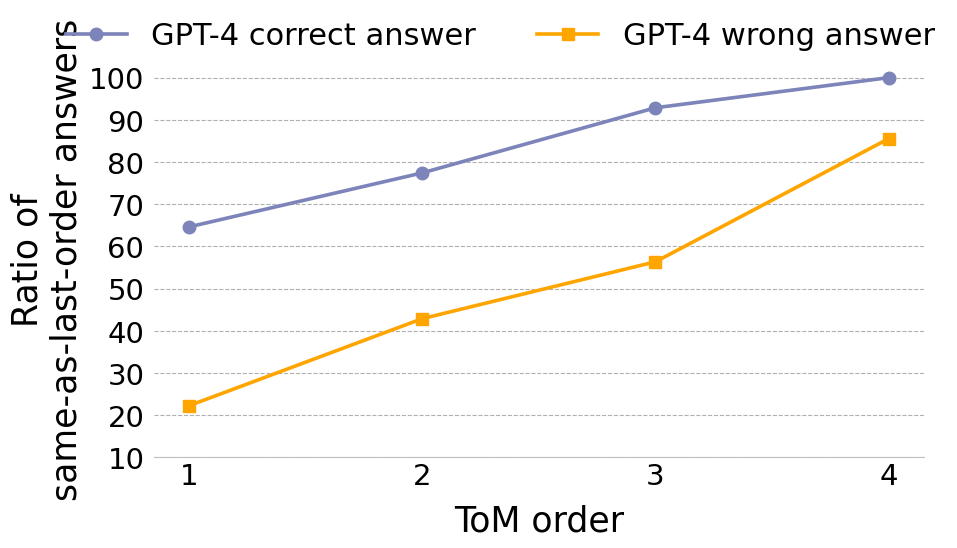

In [355]:
"""Plot: same-as-last ratio in GPT-4 correct answer"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title

markers = ['o', 's', '^', 'D', 'o']
ratio_same_correct = {'No_Tell': np.zeros(4), 'Tell': np.zeros(4)}
ratio_same_incorrect = {'No_Tell': np.zeros(4), 'Tell': np.zeros(4)}

for tell, order in itertools.product(tells, range(1,5)):
    ratio_same_correct[tell][order-1] = cnt_correct_same[tell][order] / cnt_correct[tell][order]
    ratio_same_incorrect[tell][order-1] = cnt_incorrect_same[tell][order] / cnt_incorrect[tell][order]

colors = ['#7C84B9', 'orange', 'lightcoral', 'steelblue']
plt.figure(figsize=(9, 5.5))
for tell in ['Tell']:
    plt.plot([1,2,3,4], 100 * ratio_same_correct[tell], linewidth=2.6, marker=markers[0], label='GPT-4 correct answer', markersize=9, color=colors[0])
    plt.plot([1,2,3,4], 100 * ratio_same_incorrect[tell], linewidth=2.6, marker=markers[1], label='GPT-4 wrong answer', markersize=9, color=colors[1])

# 添加标题和轴标签
# plt.title('Multiple Line Plot')
ax = plt.gca()
plt.xlabel('ToM order', labelpad=10)
plt.ylabel('Ratio of\nsame-as-last-order answers')

plt.xticks([1,2,3,4])
plt.yticks([10,20,30,40,50,60,70,80,90,100])
plt.grid(axis='y', linestyle='dashed', which='both')
# plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('silver')
plt.tick_params(axis='x', which='both', bottom=False, pad=0)
plt.tick_params(left=False)
# plt.yscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.45, 1.17), ncol=4, frameon=False)
plt.subplots_adjust(bottom=0.15, top=0.87, right=0.98)

plt.savefig('data_figs/jointacc_vs_deception.pdf')
plt.show()

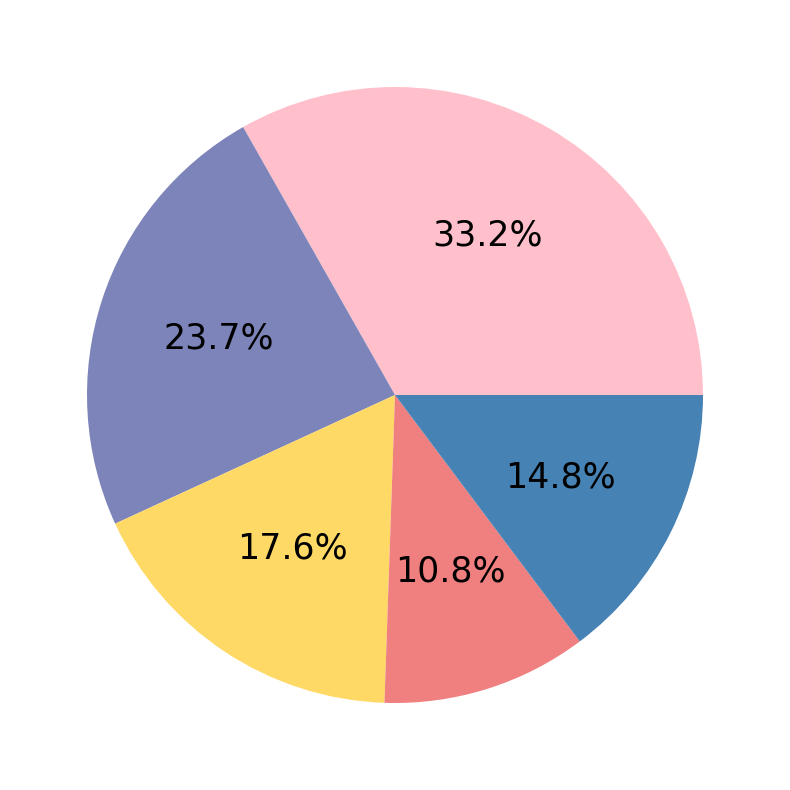

In [334]:
"""Plot: Even distribution of answers"""
import matplotlib.pyplot as plt

# Data to plot
labels = ['first fifth', 'second fifth', 'third fifth', 'fourth fifth', 'fifth fifth']
colors = ['pink', '#7C84B9', (1, 0.851, 0.4), 'lightcoral', 'steelblue']

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(correct_ans_occur, autopct='%1.1f%%', colors=colors, labeldistance=0.5)

plt.show()

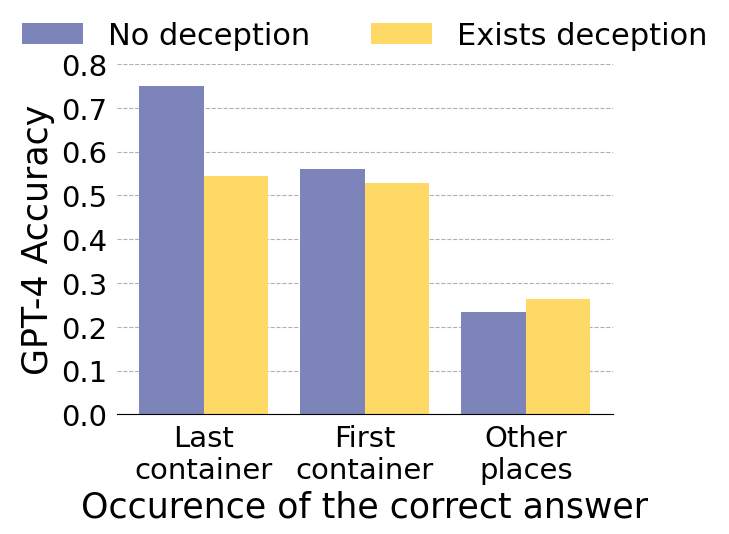

In [292]:
"""Plot: Ratio of correct/incorrect answer in first-container answers"""

occurrence = ['Last\ncontainer', 'First\ncontainer', 'Other\nplaces']
cols = ['#7C84B9', (1, 0.851, 0.4)]

# Set the positions of the bars
x = np.arange(len(occurrence))
width = 0.4

No_Tell_ratio = np.array([[0.75, 0.5609756097560976, 0.23333333333333334], [0.3969849246231156, 0.3412698412698413, 0.5555555555555556]])
Tell_ratio = np.array([[0.5434782608695652, 0.5280898876404494, 0.2638888888888889], [0.3969849246231156, 0.26, 0.3170731707317073]])
# No_Tell_ratio = np.array([[0.675, 0.5575221238938053, 0.39520958083832336], [0.3969849246231156, 0.3412698412698413, 0.5555555555555556]])
# Tell_ratio = np.array([[0.8, 0.6867924528301886, 0.5746835443037974], [0.3969849246231156, 0.26, 0.3170731707317073]])
first_ratio = []
# Create the bar chart
plt.bar(x - width/2, No_Tell_ratio[0], width, label='No deception', zorder=2, color=cols[0])
# plt.bar(x - width, 1 - No_Tell_ratio[0], width, label='Step-by-step prompting', zorder=2, color=cols[0][0])
plt.bar(x + width/2, Tell_ratio[0], width, label='Exists deception', zorder=2, color=cols[1])
# plt.bar(x + 2*width, 1 - No_Tell_ratio[1], width, label='Step-by-step prompting', zorder=2, color=cols[1][0])

# Add labels and title
plt.xlabel('Occurrence of the correct answer')
plt.ylabel('GPT-4 Accuracy')
plt.grid(axis='y', linestyle='dashed', zorder=1)
# plt.title('Bar Chart with Two Columns')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Set the x-axis tick labels
plt.xticks(x, occurrence)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.tick_params(bottom=False, left=False)

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.savefig(f'data_figs/acc_vs_occurrence.pdf')
plt.show()


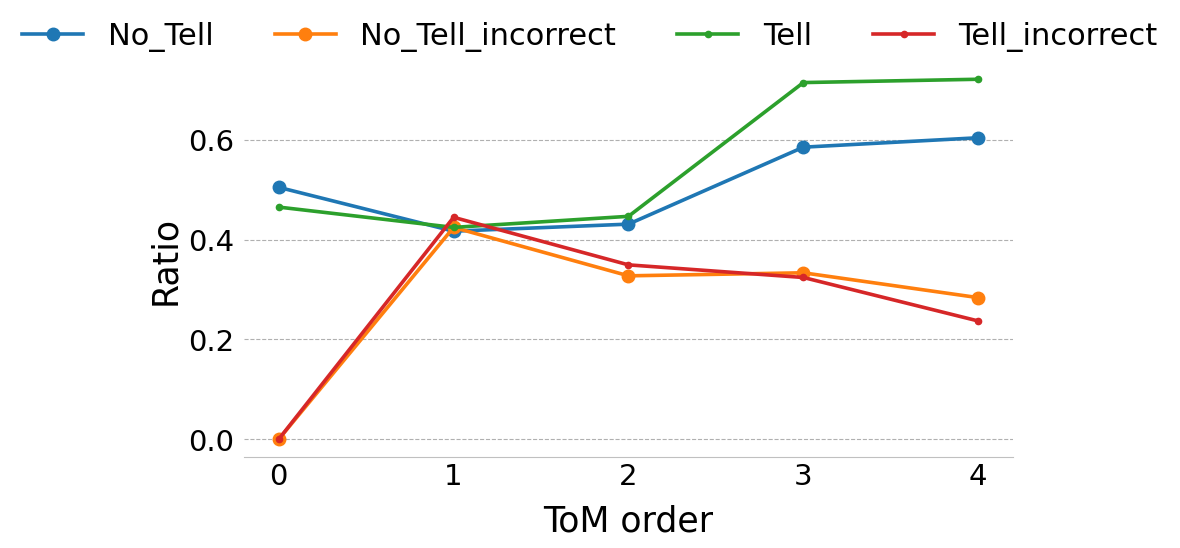

In [209]:
"""Plot ratio of first container in correct answers"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title

markers = ['o', '.', '^', 'D', 'o']
ratio_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
ratio_first_incorrect = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
joint_ratio_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}


for tell, order in itertools.product(tells, orders):
    ratio_first[tell][order] = count_correct_first[tell][order] / count_correct[tell][order]
    ratio_first_incorrect[tell][order] = count_incorrect_first[tell][order] / count_incorrect[tell][order]
    joint_ratio_first[tell][order] = joint_count_correct_first[tell][order] / joint_count_correct[tell][order]

colors = ['#7C84B9', 'orange', 'lightcoral', 'steelblue']
plt.figure(figsize=(9, 5.5)) 
for i, tell in enumerate(tells):
    # plt.plot([0,1,2,3,4], joint_ratio_first[tell], linewidth=2.6, marker=markers[i], label=tell+'_joint', markersize=9)
    plt.plot([0,1,2,3,4], ratio_first[tell], linewidth=2.6, marker=markers[i], label=tell, markersize=9)
    plt.plot([0,1,2,3,4], ratio_first_incorrect[tell], linewidth=2.6, marker=markers[i], label=tell+'_incorrect', markersize=9)

# 添加标题和轴标签
# plt.title('Multiple Line Plot')
ax = plt.gca()
plt.xlabel('ToM order', labelpad=10)
plt.ylabel('Ratio')

plt.xticks([0,1,2,3,4])
# plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
plt.grid(axis='y', linestyle='dashed', which='both')
# plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('silver')
plt.tick_params(axis='x', which='both', bottom=False, pad=0)
plt.tick_params(left=False)
# plt.yscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.45, 1.17), ncol=4, frameon=False)
plt.subplots_adjust(bottom=0.15, top=0.87, right=0.98)

plt.savefig('data_figs/jointacc_vs_deception.pdf')
plt.show()